In [0]:
import keras
# weight = 모델 초기화 가중치 체크포인트 지정
# include_top 최상위 완전 연결 분류기 포함 여부(default = 완전 연결 분류기 포함)
# 우리는 별도의 강아지+고양이 클래스 구분했던 거 추가할 거니까 선택 x
# input_shape = 네트워크에 주입할 텐서 크기, 입력하지 않으면 어떤 크기든 맞춰서 처리해주는 듯
from keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

Using TensorFlow backend.






58892288/58889256 [==============================] - 5s 0us/step








In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## (4, 4, 512) 마지막 층 위에 완전 연결층 놓을 거임
- 새로운 dataset에서 합성곱 층 실행하고 출력을 넘파이 배열로 저장 후 데이터를 완전 연결 분류기에 입력으로 사용.
- 또는 준비된 모델 위애 Dense로 확장하고 입력 데이터에서 end to end로 전체 모델 실행
모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식 사용 가능
첫 번째보다 품이 많이 듦

In [0]:
import zipfile

In [0]:
1+1

2

In [0]:

 
try:
    with zipfile.ZipFile("/content/drive/My Drive/dataset/train.zip") as zf:
        zf.extractall('./data')
        print("uncompress success")
 
except:
    print("uncompress fail")



uncompress success


In [0]:
import os, shutil
original_dataset_dir = './data'
base_dir = './cat_and_dogs_small'
if os.path.exists(base_dir):
  shutil.rmtree(base_dir)
os.mkdir(base_dir)

# train, val, test split
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# train cat, dog dir
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# val cat, dog dir
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# test cat, dog dir
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [0]:
# for 1000 cat image train_cats_dir copy
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cats_dir, fname)
  shutil.copyfile(src, dst)

# for 500 cat image val_cats_dir copy
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_cats_dir, fname)
  shutil.copyfile(src, dst)

# for 500 cat image test_cats_dir copy
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_cats_dir, fname)
  shutil.copyfile(src, dst)

# for 1000 dog image train_dogs_dir copy
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_dogs_dir, fname)
  shutil.copyfile(src, dst)

# for 500 dog image val_dogs_dir copy
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_dogs_dir, fname)
  shutil.copyfile(src, dst)

# for 500 dog image test_dogs_dir copy
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir, fname)
  shutil.copyfile(src, dst)

In [0]:
# 제대로 했는지 확인
print('train cat, dog: ', len(os.listdir(train_cats_dir)), 
      len(os.listdir(train_dogs_dir)))

train cat, dog:  1000 1000


In [0]:
# 제대로 했는지 확인
print('val cat, dog: ', len(os.listdir(validation_cats_dir)), 
      len(os.listdir(validation_dogs_dir)))

val cat, dog:  500 500


In [0]:
# 제대로 했는지 확인
print('test cat, dog: ', len(os.listdir(test_cats_dir)), 
      len(os.listdir(test_dogs_dir)))

test cat, dog:  500 500


In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# train, val, test 있는 root 폴더랑 다 명시해줌
base_dir = './cat_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 이미지를 이 gener로 갖고 올 때는 다 리스케일
datagen = ImageDataGenerator(rescale = 1./255)
# 20개씩 끊어서 갖고 옴
batch_size = 20

# 경로랑 몇 개 가져올지 입력으로 받음
def extract_features(directory, sample_count):
  # 마지막 층 거치면 이 shape가 나옴, 똑같이 만들어 줘야 값 저장 가능
  features = np.zeros(shape = (sample_count, 4, 4, 512))
  # 정답란
  labels = np.zeros(shape = (sample_count))
  # 20개씩 끊어서 갖고 옴, 바이너리 형식
  generator = datagen.flow_from_directory(
      directory,
      target_size = (150, 150),
      batch_size = batch_size,
      class_mode = 'binary')
  
  i= 0
  for inputs_batch, labels_batch in generator:
    # 나오는 결과물들을 신경망에 바로 넣어줌
    features_batch = conv_base.predict(inputs_batch)
    # 결과를 20개씩 차곡차곡 쌓아줌
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1

    # 원하는 만큼 뽑아주면 break
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# 어려워할 거 없음 그냥 이미지를 vgg에 한 번 넣은 거임
# 완전 연결 분류기에 주입 전 sample * 8192으로 변환
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [0]:
# fully conected layer define, and saved data + label train
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4* 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels,
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 570us/step - loss: 0.5736 - acc: 0.6920 - val_loss: 0.4302 - val_acc: 0.8410
Epoch 2/30
2000/2000 [==============================] - 1s 407us/step - loss: 0.4187 - acc: 0.8145 - val_loss: 0.3546 - val_acc: 0.8750
Epoch 3/30
2000/2000 [==============================] - 1s 416us/step - loss: 0.3555 - acc: 0.8470 - val_loss: 0.3263 - val_acc: 0.8630
Epoch 4/30
2000/2000 [==============================] - 1s 405us/step - loss: 0.3145 - acc: 0.8730 - val_loss: 0.2977 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 1s 414us/step - loss: 0.2796 - acc: 0.8900 - val_loss: 0.3078 - val_acc: 0.8670
Epoch 6/30
2000/2000 [==============================] - 1s

In [0]:
# 디게 빠르다.
import matplotlib.pyplot as plt

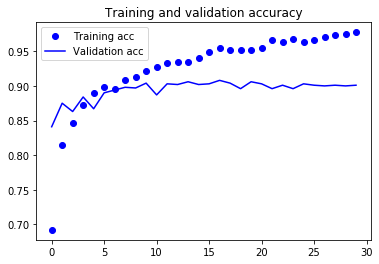

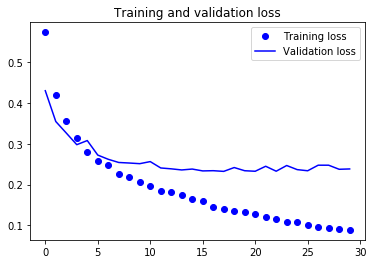

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# 이전에 에폭 100으로 하고 이미지 변환한 거보다 더 빠르긴 하다.
# 하지만 드롭아웃을 반이나 끊어줬는데 과대적합이 된다.
# 여기서는 데이터 증식을 사용해주지 않아서 그런가 보다.

In [0]:
# 이제 두 번째 방법(vgg 아래에 완전연결분류기 정의)
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [0]:
# 훈련 전 합성곱 기반층을 밀봉하는 게 중요.
# 그렇지 않으면 미리 훈련된 합성곱 기반층과 훈련되지 않은 완전연결층이 섞임
print('conv_base 동결 전 훈련되는 가중치의 수: ', len(model.trainable_weights))

conv_base 동결 전 훈련되는 가중치의 수:  30


In [0]:
conv_base.trainable = False # conv_base 전체 다 얼림

In [0]:
print('conv_base 동결 후 훈련되는 가중치의 수: ', len(model.trainable_weights))

conv_base 동결 후 훈련되는 가중치의 수:  4


In [0]:
# 스위치처럼 on off 할 수 있는듯

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest')

# 검증 데이터는 학습 x
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 2e-5),
              metrics = ['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 27s 273ms/step - loss: 0.5366 - acc: 0.7525 - val_loss: 0.4209 - val_acc: 0.8410
Epoch 2/30
100/100 [==============================] - 25s 255ms/step - loss: 0.3955 - acc: 0.8385 - val_loss: 0.3580 - val_acc: 0.8290
Epoch 3/30
100/100 [==============================] - 26s 255ms/step - loss: 0.3549 - acc: 0.8585 - val_loss: 0.3014 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 25s 255ms/step - loss: 0.3215 - acc: 0.8645 - val_loss: 0.2828 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 26s 255ms/step - loss: 0.2962 - acc: 0.8790 - val_loss: 0.2678 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 25s 251ms/step - loss: 0.2812 - acc: 0.8840 - val_loss: 0.2624 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 25s 255ms/step - loss: 0.2761 - acc: 0.8895 - val_lo

In [0]:
from google.colab import files
model.save('cats_and_dogs_small_3.h5')

KeyboardInterrupt: ignored

In [0]:
files.download('./cats_and_dogs_small_3.h5')

KeyboardInterrupt: ignored

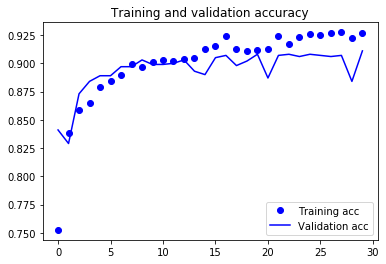

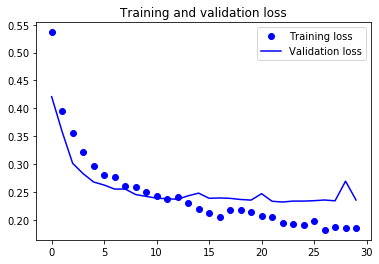

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [0]:
# 증식 안 하면 첫 번째 모델과 결과값이 같을까?

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [0]:
conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100, # 20 * 100 = 2000
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50) # 20 * 50 = 1000

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 22s 218ms/step - loss: 0.5112 - acc: 0.7745 - val_loss: 0.4000 - val_acc: 0.8490
Epoch 2/30
100/100 [==============================] - 20s 205ms/step - loss: 0.3470 - acc: 0.8650 - val_loss: 0.3211 - val_acc: 0.8840
Epoch 3/30
100/100 [==============================] - 20s 204ms/step - loss: 0.2880 - acc: 0.8935 - val_loss: 0.2892 - val_acc: 0.8940
Epoch 4/30
100/100 [==============================] - 20s 204ms/step - loss: 0.2506 - acc: 0.9075 - val_loss: 0.2714 - val_acc: 0.9000
Epoch 5/30
100/100 [==============================] - 20s 204ms/step - loss: 0.2248 - acc: 0.9245 - val_loss: 0.2614 - val_acc: 0.9030
Epoch 6/30
100/100 [==============================] - 20s 204ms/step - loss: 0.2043 - acc: 0.9315 - val_loss: 0.2519 - val_acc: 0.9040
Epoch 7/30
100/100 [==============================] - 20s 203ms/step - loss: 0.1870 - acc: 0.9375 - val_lo

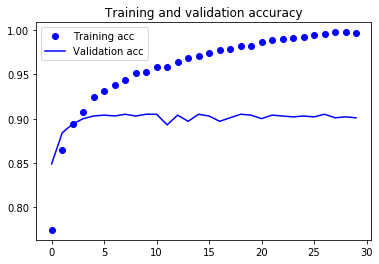

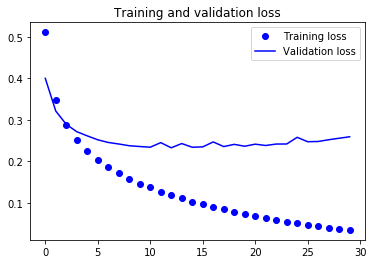

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 미세조정
![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [0]:
# 일부 동결층을 해제하고 동결을 해제한 층과 새로 추가한 층을 함께 훈련하자

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
# black5_conv1~3만 다시 학습해보자.
# 아래 층일수록 특화된 특성을 인코딩하고, 먼저 쌓은 층일수록 일반적이고 재사용 가능한 특성을 학습함
# 그래서 밑에 거 몇 개만 미세조정

In [0]:
conv_base.trainable = True # 전체 다 학습 못하게 해줌

set_trainable = False # 

# block5_conv1 만날 때부터 해당 층은 다 활성화시켜주기
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
[i.name for i in conv_base.layers]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

In [0]:
type(set_trainable)

bool

In [0]:
# 학습량을 낮춰서 진행해보자
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-5),
              metrics = ['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 29s 286ms/step - loss: 0.2048 - acc: 0.9110 - val_loss: 0.2506 - val_acc: 0.9060
Epoch 2/100
100/100 [==============================] - 26s 263ms/step - loss: 0.1575 - acc: 0.9385 - val_loss: 0.2505 - val_acc: 0.9080
Epoch 3/100
100/100 [==============================] - 26s 261ms/step - loss: 0.1377 - acc: 0.9450 - val_loss: 0.2150 - val_acc: 0.9210
Epoch 4/100
100/100 [==============================] - 26s 261ms/step - loss: 0.1141 - acc: 0.9565 - val_loss: 0.2156 - val_acc: 0.9210
Epoch 5/100
100/100 [==============================] - 26s 260ms/step - loss: 0.1105 - acc: 0.9565 - val_loss: 0.2142 - val_acc: 0.9190
Epoch 6/100
100/100 [==============================] - 26s 256ms/step - loss: 0.0975 - acc: 0.9630 - val_loss: 0.2213 - val_acc: 0.9210
Epoch 7/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0714 - acc: 0.9695 - val_loss: 0.2336 - val_acc: 0.9220
Epoch 8/100
100/100 [===========================

In [0]:
model.save('cats_and_dogs_small_4.h5')
files.download('./cats_and_dogs_small_4.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 34086, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

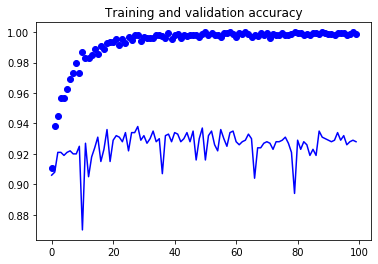

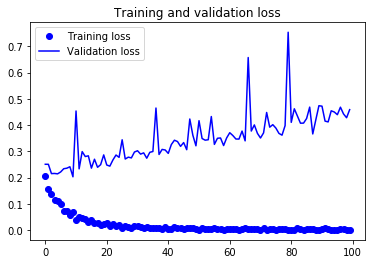

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc') 
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs , val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

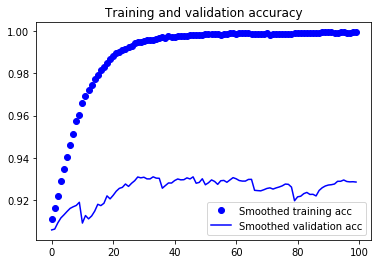

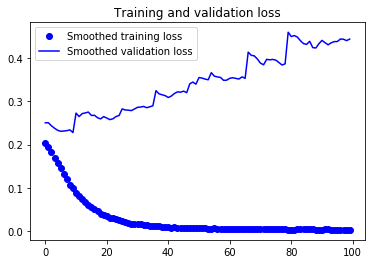

In [0]:
# 지수이동 평균으로 보자
def smooth_curve(points, factor = 0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')
# 20 * 50 하면 딱 샘플 1천 개 다 쓰는 거
test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9319999897480011
